In [4]:
### IMPORTS ###
import os
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import warnings
import phate


In [5]:
warnings.filterwarnings('ignore')

# Running PCAs on genome scale metabolic models

The goal is to identify relevant metabolic preferences of bacteria in a given media. I have started to simulate growth of 0.1 in M9 media.

So far the results are presented for 3800 models without any specific grouping that will result from a phylogenetic tree construction. The goal is to build a representative sampling of species to identify specific metabolic strategies.

## Media list

In [6]:
# I want to get the data set that contains the growth mediums
media_list = pd.read_csv("../data/media_db.tsv", sep='\t')

# I want now to filter only the media of interest
growth_media = "M9"
media_list = media_list[media_list['medium'] == growth_media]

# Create a variable with the exchange reactions from the "compound" column
exchange_reactions = media_list['compound'].tolist()

# for every element in the exchange_reactions list, I will add "EX_" and "_e" to the beginning and end of the string
exchange_reactions = ['EX_' + x + '_e' for x in exchange_reactions]

# add the exchange reactions to the media dataframe
media_list['exchange_reactions'] = exchange_reactions
media_list

,medium,description,compound,name,exchange_reactions
129,M9,M9 minimal medium,ca2,Ca2+,EX_ca2_e
130,M9,M9 minimal medium,cl,Cl-,EX_cl_e
131,M9,M9 minimal medium,cobalt2,Co2+,EX_cobalt2_e
132,M9,M9 minimal medium,cu2,Cu2+,EX_cu2_e
133,M9,M9 minimal medium,fe2,Fe2+,EX_fe2_e
134,M9,M9 minimal medium,fe3,Fe3+,EX_fe3_e
135,M9,M9 minimal medium,glc__D,D-Glucose,EX_glc__D_e
136,M9,M9 minimal medium,h2o,H2O,EX_h2o_e
137,M9,M9 minimal medium,h,H+,EX_h_e
138,M9,M9 minimal medium,k,K+,EX_k_e


In [7]:
# create list with variable for 'growth_rate' and 'exchange_reactions'
media_list = media_list['exchange_reactions'].tolist()

# Data processing

In [8]:
# find file with a pattern
files = glob.glob("../results_v2/*specieslist*")

In [9]:
# Append all the files into a single dataframe with common columns
df_list = []
for i in files:
    df = pd.read_csv(i)
    df_list.append(df)
    
# Concatenate all the dataframes into a single dataframe
df = pd.concat(df_list)
df

,species_name,growth,EX_ca2_e,EX_cl_e,EX_cobalt2_e,EX_cu2_e,EX_fe2_e,EX_fe3_e,EX_glc__D_e,EX_h2o_e,...,EX_mg2_e,EX_mn2_e,EX_mobd_e,EX_na1_e,EX_nh4_e,EX_ni2_e,EX_o2_e,EX_pi_e,EX_so4_e,EX_zn2_e
0,Azorhizobium_caulinodans,0.100000,0.000521,0.000521,0.000010,0.000071,0.000672,0.000781,1.049461,0.0,...,0.000867,0.000069,0,0,1.119722,0,2.084954,0.098609,0.025063,0.000034
1,Buchnera_aphidicola,0.100000,0.000521,0.000521,0.000010,0.000071,0.001452,0.000000,1.964923,0.0,...,0.000867,0.000069,0,0,1.119722,0,2.212258,0.098609,0.106409,0.000034
2,Cellulomonas_gilvus,0.100000,0.000521,0.000521,0.000010,0.000071,0.001452,0.000000,1.637607,0.0,...,0.000867,0.000069,0,0,1.119722,0,2.343930,0.098609,0.025063,0.000034
3,Dictyoglomus_thermophilum,0.100000,0.000521,0.000521,0.000010,0.000071,0.001452,0.000000,3.219575,0.0,...,0.000867,0.000069,0,0,1.119722,0,1.363879,0.098609,0.509042,0.000034
4,Methylophilus_methylotrophus,0.100000,0.000521,0.000521,0.000010,0.000071,0.001452,0.000000,1.327962,0.0,...,0.000867,0.000069,0,0,1.119722,0,3.513700,0.098609,0.025063,0.000034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,Caryophanon_latum,0.100000,0.000521,0.000521,0.000010,0.000071,0.001452,0.000000,4.280718,0.0,...,0.000867,0.000069,0,0,1.119722,0,0.221836,0.098609,0.025063,0.000034
6,Caryophanon_tenue,0.100000,0.000521,0.000521,0.000010,0.000071,0.001452,0.000000,4.188873,0.0,...,0.000867,0.000069,0,0,1.119722,0,0.150066,0.098609,0.025063,0.000034
7,Exiguobacterium_aurantiacum,0.100000,0.000521,0.000521,0.000010,0.000071,0.001452,0.000000,1.100790,0.0,...,0.000867,0.000069,0,0,1.119722,0,2.497202,0.098609,0.025063,0.000034
8,Rickettsia_amblyommatis,0.083042,0.000432,0.000432,0.000008,0.000059,0.000484,0.000722,2.307930,0.0,...,0.000720,0.000057,0,0,0.929836,0,10.000000,0.081887,0.020812,0.000028


In [10]:
# drop all the rows that growth rate is lower than 0.1
df = df[df['growth'] == 0.1]

# drop species_name and growth columns
df = df.drop(columns=['species_name', 'growth'])

In [11]:
data = df

# PCAs

In [12]:
# Create an instance of the PCA class
pca = PCA(n_components=5)

# Fit the PCA model to your data
pca.fit(data)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Get the principal components (eigenvectors)
principal_components = pca.components_

In [13]:
explained_variance_ratio
# principal_components

array([0.47576252, 0.32819446, 0.12794848, 0.02635834, 0.02380151])

In [14]:
sum(explained_variance_ratio)

0.9820653094854122

### Loadings of the first 3 components

In [15]:
principal_components[0:3]

array([[-1.11022302e-16, -7.73675337e-36,  6.39863902e-23,
        -7.69897841e-22,  2.48228677e-02,  4.97058507e-03,
         8.55831185e-01,  5.16164064e-03,  4.57085931e-02,
        -1.64907372e-19, -4.50657988e-36,  5.38745420e-20,
         0.00000000e+00,  0.00000000e+00,  3.01802197e-02,
         0.00000000e+00,  5.12922471e-01,  5.48671792e-03,
         2.76725927e-02,  3.24099674e-22],
       [ 2.91433544e-16,  1.11022302e-16,  4.30961574e-24,
         8.37433665e-22, -1.36569148e-03,  5.47265404e-03,
        -5.12731368e-01,  5.75681056e-03,  1.27566398e-01,
        -5.00863629e-19, -2.35514679e-35,  1.23425978e-19,
         0.00000000e+00,  0.00000000e+00, -3.85876143e-02,
         0.00000000e+00,  8.47716037e-01,  2.70895216e-03,
        -2.54868733e-02, -2.05486208e-21],
       [-2.08166817e-17,  3.46944695e-17, -1.77946422e-26,
         2.57448140e-22,  1.05854507e-01, -3.17389836e-03,
         2.08946646e-02, -3.33582918e-03,  9.81650347e-01,
        -9.54548531e-19,  2.7

### Biplot

In [16]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Metabolite "+str(i), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    # plt.xlim(-1,1)
    # plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

In [17]:
data_new = pca.fit_transform(data)
data_new

array([[-1.37231100e+00,  4.44932984e-01, -1.46441156e-01,
        -6.03103777e-03,  1.43615101e-02],
       [-5.21266672e-01,  8.13859573e-02, -1.37254546e-01,
        -4.37070099e-02, -1.88238203e-02],
       [-7.36108314e-01,  3.62904803e-01, -1.68317022e-01,
        -2.54859746e-02,  4.87695780e-04],
       ...,
       [ 4.37479174e-01, -2.79123417e+00,  1.67561678e-01,
        -1.66525457e-01, -7.39022387e-02],
       [ 3.22063465e-01, -2.80498306e+00,  1.75134343e-01,
        -1.64021671e-01, -7.16987566e-02],
       [-1.09781516e+00,  8.21385113e-01,  2.10402583e-01,
         6.60776131e-03, -2.45926555e-02]])

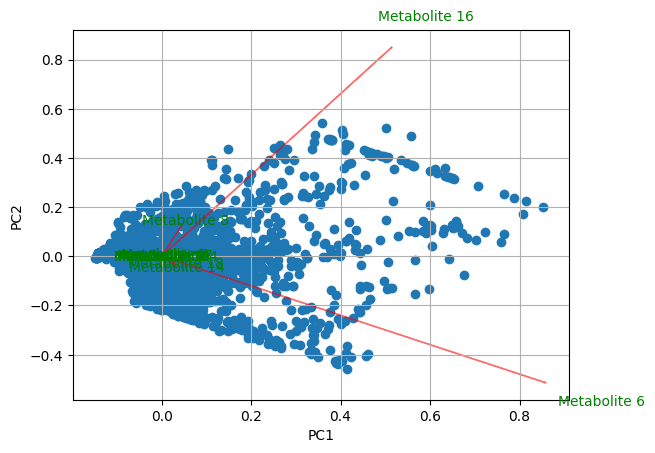

In [18]:
#Call the function. Use only the 2 PCs.
myplot(data_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

### Finding the most influential metabolites

In [19]:
metabolic_data = PCA(n_components=5).fit(data)
n_pcs = metabolic_data.n_components_

influential_met = [np.abs(metabolic_data.components_[i]).argmax() for i in range(n_pcs)]
influential_met

[6, 16, 8, 14, 4]

In [20]:
initial_feature_names = media_list

# get the names
influential_met = [initial_feature_names[influential_met[i]] for i in range(n_pcs)]

# # LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i+1): influential_met[i] for i in range(n_pcs)}
dic

{'PC1': 'EX_glc__D_e',
 'PC2': 'EX_o2_e',
 'PC3': 'EX_h_e',
 'PC4': 'EX_nh4_e',
 'PC5': 'EX_fe2_e'}

In [21]:
df = pd.DataFrame(dic.items())
df

,0,1
0,PC1,EX_glc__D_e
1,PC2,EX_o2_e
2,PC3,EX_h_e
3,PC4,EX_nh4_e
4,PC5,EX_fe2_e


So, most of the variation in the dataset is explained by the uptake of glucose using oxygen and hydrogen protons to assist in the reactions.

I could not dig too much on this variation, but I believe the representation of specific clades possibly will give some light into some particular group strategies. This could be somehow tru because I (again) used the previous code to run K means clustering...and this time, it divided the data set into 9 clusters.

This is calculated by a silhouette score ([silhouette analysis on KMeans clustering](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)) that is used to evaluate the quality of clusters created in terms of how well samples are clustered with other samples that are similar to each other.

### K Means

I will just leave some representation of the K means and will also include the PHATE (Potential of Heat-diffusion for Affinity-based Trajectory Embedding) that also confirms some of these structuring. These can used in further analysis in addition to the exploration of PCAs, if time allows.


PHATE (Potential of Heat-diffusion for Affinity-based Trajectory Embedding) is a tool for visualizing high dimensional data. PHATE uses a novel conceptual framework for learning and visualizing the manifold to preserve both local and global distances.

In [22]:
# Define a range of cluster numbers to evaluate
min_clusters = 2
max_clusters = 15

best_cluster_num = None
best_silhouette_score = -1

# Iterate over different cluster numbers
for num_clusters in range(min_clusters, max_clusters+1):
    # Create an instance of the KMeans class with the current number of clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)

    # Fit the K-means model to your normalized data
    kmeans.fit(data)

    # Get the cluster labels assigned to each data point
    cluster_labels = kmeans.labels_

    # Calculate the silhouette score for the current clustering
    silhouette_avg = silhouette_score(data, cluster_labels)

    # Print the silhouette score for the current number of clusters
    print(f"Number of clusters: {num_clusters} | Silhouette score: {silhouette_avg}")

    # Update the best cluster number and silhouette score if necessary
    if silhouette_avg > best_silhouette_score:
        best_cluster_num = num_clusters
        best_silhouette_score = silhouette_avg

# Print the best cluster number and silhouette score
print(f"\nBest number of clusters: {best_cluster_num}")
print(f"Best silhouette score: {best_silhouette_score}")


Number of clusters: 2 | Silhouette score: 0.4849359869710777
Number of clusters: 3 | Silhouette score: 0.529943050697618
Number of clusters: 4 | Silhouette score: 0.5494187357811635
Number of clusters: 5 | Silhouette score: 0.5495088401656824
Number of clusters: 6 | Silhouette score: 0.5685336662977074
Number of clusters: 7 | Silhouette score: 0.5724066587979552
Number of clusters: 8 | Silhouette score: 0.5741758775702772
Number of clusters: 9 | Silhouette score: 0.5888886702087383
Number of clusters: 10 | Silhouette score: 0.5465365289951004
Number of clusters: 11 | Silhouette score: 0.46901263842442276
Number of clusters: 12 | Silhouette score: 0.4758737926167115
Number of clusters: 13 | Silhouette score: 0.47805400058850733
Number of clusters: 14 | Silhouette score: 0.4777076785897575
Number of clusters: 15 | Silhouette score: 0.4622857534023078

Best number of clusters: 9
Best silhouette score: 0.5888886702087383


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


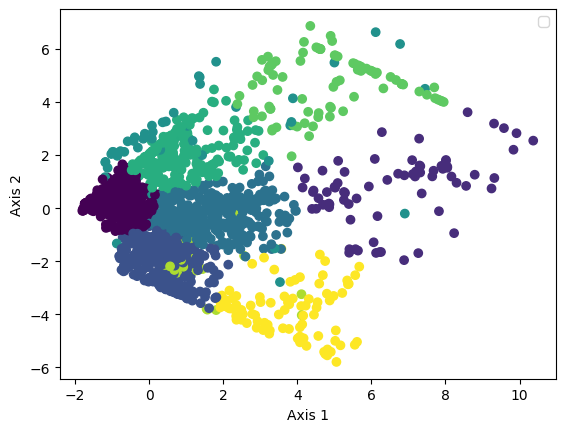

In [23]:
# 'k' clusters
k = 9

# Create an instance of the KMeans class
kmeans = KMeans(n_clusters=k)

# Fit the K-means model to your normalized data
kmeans.fit(data)

# Get the cluster labels assigned to each data point
cluster_labels = kmeans.labels_

# Apply PCA to reduce the dimensionality to 2
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data)

# Create a scatter plot of the PCA-transformed data points
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=cluster_labels)

# Add labels and legend
plt.xlabel('Axis 1')
plt.ylabel('Axis 2')
plt.legend()

# Show the plot
plt.show()


### PHATE

Calculating PHATE...
  Running PHATE on 3732 observations and 20 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.36 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 0.41 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.31 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.47 seconds.
  Calculated landmark operator in 4.60 seconds.
  Calculating optimal t...
    Automatically selected t = 43
  Calculated optimal t in 4.11 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.96 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.05 seconds.
Calculated PHATE in 15.14 seconds.


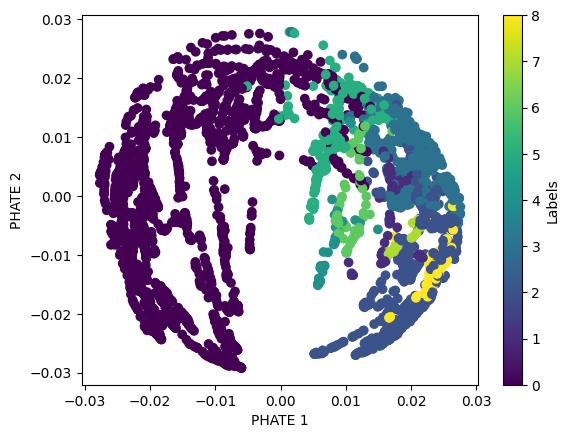

In [24]:
# Create an instance of the PHATE class
phate_op = phate.PHATE()

# Perform dimensionality reduction using PHATE
phate_result = phate_op.fit_transform(data)

# Plot the PHATE visualization
plt.scatter(phate_result[:, 0], phate_result[:, 1], c=cluster_labels)
plt.xlabel('PHATE 1')
plt.ylabel('PHATE 2')
plt.colorbar(label='Labels')
plt.show()

